<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/anomalias/src/Anomalias_vizcaina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install windrose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import timedelta
import matplotlib.cm as cm
from functools import reduce
from math import cos, sin, atan, pi
from windrose import WindroseAxes
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'
PATH_DADOS_EVENTOS = '/dados/'
PATH_ANOMALIAS = '/anomalias/'
NOMBRE_ESTACION = 'vizcaina'
FILE_DATOS_ESTACION = 'eventos_vizcaina_2.csv'

LISTA_VAR = ['temp', 'hum', 'pres']
LISTA_PWV = []
LISTA_VAR_10M = ['viento']
LISTA_PREC = ['prec']

PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'
FILES_TRATADOS = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR]
FILES_PWV = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PWV]
FILES_TRATADOS_10M = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR_10M]
FILES_TRATADOS_PREC = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PREC]

Cargando datos de Temp, Hum, Pres

In [4]:
dfList = []
for f in FILES_TRATADOS:
  df = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(df)

In [5]:
df = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
df = df.sort_values(by=['FECHA']).reset_index(drop = True)
df['HORA'] = df['FECHA'].apply(lambda x: x[11:13])

Cargando datos de Vapor de Agua

In [6]:
dfList = []
PWV_columns = []
if FILES_PWV:
    
  for f in FILES_PWV:
    dfp = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                    sep = ';', 
                  )
    dfList.append(dfp)
    PWV_columns += [col for col in dfp if col != 'FECHA']


  dfPWV = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
  dfPWV = dfPWV.sort_values(by=['FECHA']).reset_index(drop = True)

  dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
  dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()

  for var in PWV_columns:
    dfPWV = dfPWV.loc[~dfPWV[var].isnull()].reset_index(drop = True)

  dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
else:
  dfPWV = pd.DataFrame(columns = ['FECHA', 'PWV'])

In [7]:
dfPWV

,FECHA,PWV


## Cargando datos de Vientos

$ \theta_p  = arctan(U_p / V_p) $ Direccíon del viento promedio

In [8]:
dfList = []
for f in FILES_TRATADOS_10M:
  dfaux = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(dfaux)

In [9]:
df10m = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)

df10m['FECHA_HORA'] = df10m['FECHA'].apply(lambda x: x[0:13])
df10m['X_VIENTO'] = df10m['VELVIENTO'] * np.sin(np.deg2rad(df10m['DIRECVIENTO'] - 180))
df10m['Y_VIENTO'] = df10m['VELVIENTO'] * np.cos(np.deg2rad(df10m['DIRECVIENTO'] - 180))

dfViento = df10m.copy()

df10m = df10m.groupby('FECHA_HORA').agg({'X_VIENTO' : 'mean', 'Y_VIENTO' : 'mean' }).reset_index()
df10m['HORA'] = df10m['FECHA_HORA'].apply(lambda x: x[11:13])
df10m['FECHA'] = pd.to_datetime(df10m['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)

## Cargando datos de precipitación

In [10]:
dfList = []
PREC_columns = []
if FILES_TRATADOS_PREC:
    
  for f in FILES_TRATADOS_PREC:
    dfp = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                    sep = ';', 
                  )
    dfList.append(dfp)
    PREC_columns += [col for col in dfp if col != 'FECHA']


  dfPrec = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
  dfPrec = dfPrec.sort_values(by=['FECHA']).reset_index(drop = True)

  # dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
  # dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()

  for var in PREC_columns:
    dfPrec = dfPrec.loc[~dfPrec[var].isnull()].reset_index(drop = True)

  # dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
else:
  dfPrec = pd.DataFrame(columns = ['FECHA'])



In [11]:
dfPrec

,FECHA,PREC
0,2011-01-01 00:10:00-05:00,0.0
1,2011-01-01 00:20:00-05:00,0.0
2,2011-01-01 00:30:00-05:00,0.0
3,2011-01-01 00:40:00-05:00,0.0
4,2011-01-01 00:50:00-05:00,0.0
...,...,...
307957,2017-12-31 23:10:00-05:00,0.0
307958,2017-12-31 23:20:00-05:00,0.0
307959,2017-12-31 23:30:00-05:00,0.0
307960,2017-12-31 23:40:00-05:00,0.0


## Cruzamiento de datos de Temp, hum y pres con PWV

In [12]:
dfDatos = pd.merge(df[['FECHA', 'TEMP', 'HUM', 'PRESION']], dfPWV[['FECHA', 'PWV']], on = 'FECHA', how = 'outer')
dfDatos['HORA'] = dfDatos['FECHA'].apply(lambda x: x[11:13])

dfmean = dfDatos.groupby('HORA').agg('mean').reset_index(level=0)

columns_mean = [col for col in dfmean.columns if col != 'HORA']
for col in columns_mean:
  dfmean = dfmean.rename(columns={col : f'{col}_mean'})

dfmean

,HORA,TEMP_mean,HUM_mean,PRESION_mean
0,00,24.940379,97.182825,1002.528390
1,01,24.658066,97.686138,1002.229700
2,02,24.389596,98.116690,1002.077061
3,03,24.145021,98.494845,1002.064574
4,04,23.934742,98.794035,1002.341801
5,05,23.738659,98.998600,1002.881911
6,06,23.622704,99.182158,1003.515191
7,07,24.827433,97.525376,1004.405851
8,08,26.731766,88.216884,1004.908196
9,09,29.174911,79.913592,1003.285490


## Cargando Df de los eventos

In [13]:
dfEventos = pd.read_csv(PATH_DRIVE + PATH_DADOS_EVENTOS + FILE_DATOS_ESTACION, 
                 sep = ';'
                )
dfEventos = dfEventos.sort_values(by='date_min_t').reset_index(drop = True)
dfEventos['FECHA'] = pd.to_datetime(dfEventos['date_min_t'], format='%Y %m %d %H %M').dt.tz_localize('America/Bogota')
dfEventos['FECHA_MIN'] = dfEventos['FECHA'].dt.round('10min')  
dfEventos['FECHA'] = dfEventos['FECHA'].dt.round('H')
dfEventos = dfEventos[['FECHA', 'FECHA_MIN', 'min_t', 'lon_t', 'lat_t']]
dfEventos

,FECHA,FECHA_MIN,min_t,lon_t,lat_t
0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058
1,2011-03-09 01:00:00-05:00,2011-03-09 01:20:00-05:00,216.9,-73.693,6.915
2,2011-04-23 20:00:00-05:00,2011-04-23 20:20:00-05:00,196.2,-73.693,6.915
3,2011-04-25 01:00:00-05:00,2011-04-25 01:20:00-05:00,199.6,-73.693,6.772
4,2011-06-07 05:00:00-05:00,2011-06-07 05:20:00-05:00,193.6,-73.693,7.058
5,2011-06-19 04:00:00-05:00,2011-06-19 04:20:00-05:00,205.3,-73.693,7.058
6,2011-07-01 00:00:00-05:00,2011-07-01 00:20:00-05:00,188.4,-73.693,7.058
7,2011-07-19 02:00:00-05:00,2011-07-19 01:40:00-05:00,209.0,-73.693,6.772
8,2011-07-19 02:00:00-05:00,2011-07-19 01:40:00-05:00,209.0,-73.693,6.772
9,2011-08-15 03:00:00-05:00,2011-08-15 02:40:00-05:00,194.3,-73.693,7.058


# Cargando Eventos e encontrando intervalo n horas antes y después

In [14]:
funtime = lambda x, hour : [x + timedelta(hours = h) for h in (range(0, hour+1) if hour > 0 else range(hour, 0))]

# [base - datetime.timedelta(days=x) for x in range(numdays)]
dfEventAn = dfEventos.copy()
# pd.set_option('display.max_colwidth', None)

# ==================================
int_horas = 4
int_minutes = int_horas * 6 * 10
# ==================================
dfEventAn['FECHA_ANTES'] = dfEventAn['FECHA'].apply(funtime, hour = -int_horas)
dfEventAn['FECHA_DESPUES'] = dfEventAn['FECHA'].apply(funtime, hour = int_horas)
dfEventAn['FECHA_INTERVALO'] = dfEventAn['FECHA_ANTES'] + dfEventAn['FECHA_DESPUES']
dfEventAn = dfEventAn.drop(columns=['FECHA_ANTES', 'FECHA_DESPUES']).explode('FECHA_INTERVALO')
dfEventAn['FECHA_POS'] = (dfEventAn['FECHA_INTERVALO'] - dfEventAn['FECHA'])/ pd.Timedelta(hours=1)
dfEventAn = dfEventAn.rename(columns={'FECHA' : 'FECHA_EVENTO', 'FECHA_INTERVALO': 'FECHA'}).reset_index()
dfEventAn['FECHA'] = dfEventAn['FECHA'].astype(str)


dfEventAn.head(15)

,index,FECHA_EVENTO,FECHA_MIN,min_t,lon_t,lat_t,FECHA,FECHA_POS
0,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:00:00-05:00,-4.0
1,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 02:00:00-05:00,-3.0
2,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 03:00:00-05:00,-2.0
3,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 04:00:00-05:00,-1.0
4,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 05:00:00-05:00,0.0
5,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 06:00:00-05:00,1.0
6,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 07:00:00-05:00,2.0
7,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 08:00:00-05:00,3.0
8,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 09:00:00-05:00,4.0
9,1,2011-03-09 01:00:00-05:00,2011-03-09 01:20:00-05:00,216.9,-73.693,6.915,2011-03-08 21:00:00-05:00,-4.0


# Cruzamiento con las variables metereológicas. En terminos de 1h


In [15]:
dfCross = pd.merge(dfEventAn, dfDatos, on='FECHA', how = 'left')
dfCross['HORA'] = dfCross['FECHA'].apply(lambda x: x[11:13])
dfCross = pd.merge(dfCross, dfmean, on = 'HORA', how='left')

list_anomalias = []
for col in columns_mean:
  anomalia = f'{col}_anomalia'
  list_anomalias.append(anomalia)
  dfCross[anomalia] = dfCross[f'{col}'] - dfCross[f'{col}_mean'] 

dfAnomalia = dfCross[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()

In [16]:
dfAnomalia

FECHA_POS TEMP_anomalia           HUM_anomalia           PRESION_anomalia  \
                     mean       std         mean       std             mean   
0      -4.0      0.436687  0.970946    -0.075357  6.204664        -1.514169   
1      -3.0      0.572162  0.872019     0.290817  4.981313        -1.615179   
2      -2.0      0.637224  0.749931    -0.192930  5.072356        -1.061479   
3      -1.0      0.490207  0.724360    -0.205052  3.239644        -1.949233   
4       0.0      0.154805  1.071114     0.213712  2.909260        -1.630833   
5       1.0     -0.257778  1.209719    -0.188297  3.951062        -1.748815   
6       2.0     -0.509879  1.021251     0.190342  3.440603        -1.450860   
7       3.0     -0.682358  1.431416     2.160698  5.955865        -0.452696   
8       4.0     -0.866734  1.953887     3.489394  8.256050         0.295160   

             
        std  
0  1.540589  
1  1.572097  
2  3.414321  
3  1.466341  
4  1.911505  
5  1.865688  
6  2.021517  
7  3.533626  
8  3.687665

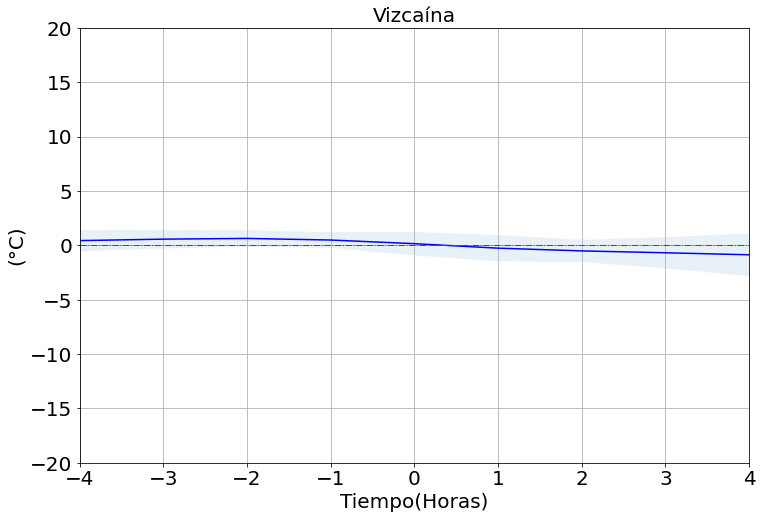

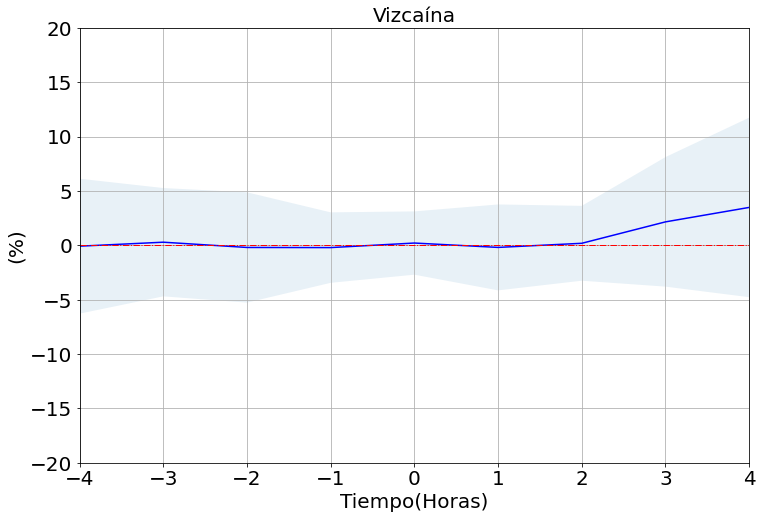

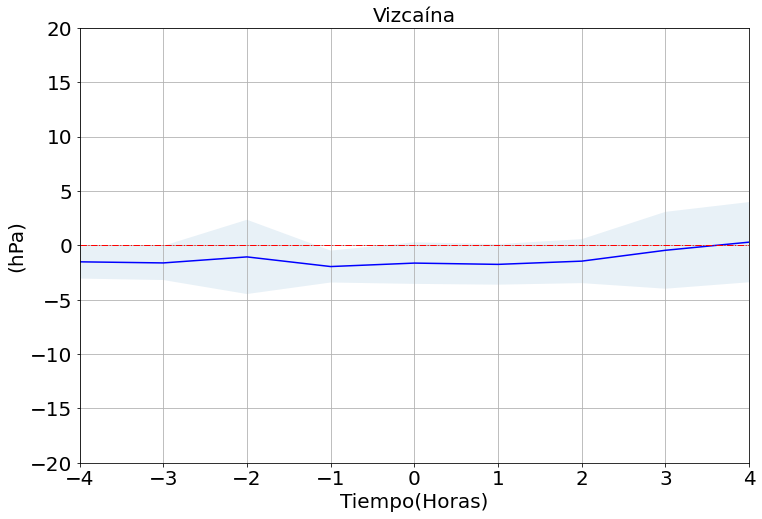

In [47]:
def plot_anomalias(df, anomalia, titulo, name_to_save, ylabel_name, int_horas, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  plt.xticks(df['FECHA_POS'], fontsize= 20)
  plt.yticks(fontsize= 20)
  plt.plot(df['FECHA_POS'], df[(anomalia, 'mean')], color = 'b')
  plt.fill_between(df['FECHA_POS'], df[(anomalia, 'mean')] + df[(anomalia, 'std')], df[(anomalia, 'mean')] - df[(anomalia, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.xlim([-int_horas, int_horas])
  plt.ylim(-20,20)
  #if ylimit:
    #plt.ylim(*ylimit)
  plt.xlabel("Tiempo(Horas)", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(%)'},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(hPa)'},
              # 'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomalia, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

# dfAnomalia

# Análisis con los 21 Eventos que tienen todas las variábles metereológicas completas

In [18]:
dfEventos0 = dfCross.loc[dfCross['FECHA_POS'] == 0.]
dfEventos0 = dfEventos0[['FECHA_EVENTO', 'min_t', 'index'] + columns_mean]
dfEventos0['NUMERO_VARS'] = dfEventos0[columns_mean].notnull().sum(axis=1)
dfEventos0

,FECHA_EVENTO,min_t,index,TEMP,HUM,PRESION,NUMERO_VARS
4,2011-02-13 05:00:00-05:00,204.5,0,24.2,96.0,NaN,2
13,2011-03-09 01:00:00-05:00,216.9,1,24.9,99.0,NaN,2
22,2011-04-23 20:00:00-05:00,196.2,2,NaN,NaN,NaN,0
31,2011-04-25 01:00:00-05:00,199.6,3,NaN,NaN,NaN,0
40,2011-06-07 05:00:00-05:00,193.6,4,24.9,100.0,NaN,2
49,2011-06-19 04:00:00-05:00,205.3,5,25.0,99.0,NaN,2
58,2011-07-01 00:00:00-05:00,188.4,6,21.1,100.0,NaN,2
67,2011-07-19 02:00:00-05:00,209.0,7,25.5,100.0,NaN,2
76,2011-07-19 02:00:00-05:00,209.0,8,25.5,100.0,NaN,2
85,2011-08-15 03:00:00-05:00,194.3,9,22.6,99.0,NaN,2


In [19]:
dfEventos0.count()

FECHA_EVENTO    39
min_t           39
index           39
TEMP            31
HUM             31
PRESION         20
NUMERO_VARS     39
dtype: int64

In [20]:
dfEventos0['NUMERO_VARS'].value_counts()

3    20
2    11
0     8
Name: NUMERO_VARS, dtype: int64

In [21]:
dfVarsCompletas = dfEventos0.loc[dfEventos0['NUMERO_VARS'] == 3]
indexVarsCompletas = dfVarsCompletas['index']
dfVarsComp = pd.merge(dfCross, indexVarsCompletas, on = 'index', how = 'inner')

dfAnomaliaVarsComp = dfVarsComp[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()
dfAnomaliaVarsComp

FECHA_POS TEMP_anomalia           HUM_anomalia           PRESION_anomalia  \
                     mean       std         mean       std             mean   
0      -4.0      0.585141  1.108299    -0.109637  7.087197        -1.514169   
1      -3.0      0.746378  0.942390     0.437160  5.680054        -1.615179   
2      -2.0      0.814817  0.703217    -0.481598  5.848520        -1.714298   
3      -1.0      0.580800  0.713602    -0.245998  3.564177        -1.949233   
4       0.0      0.302581  0.747145    -0.244298  3.388008        -1.630833   
5       1.0     -0.055969  1.105637    -0.836163  4.723116        -1.748815   
6       2.0     -0.158089  0.838915    -0.187123  4.124308        -1.573110   
7       3.0     -0.184444  1.112443     1.065116  5.852071        -1.178703   
8       4.0     -0.284268  1.562154     1.761721  7.306805        -0.477821   

             
        std  
0  1.540589  
1  1.572097  
2  1.688338  
3  1.466341  
4  1.911505  
5  1.865688  
6  1.992798  
7  2.173372  
8  2.499164

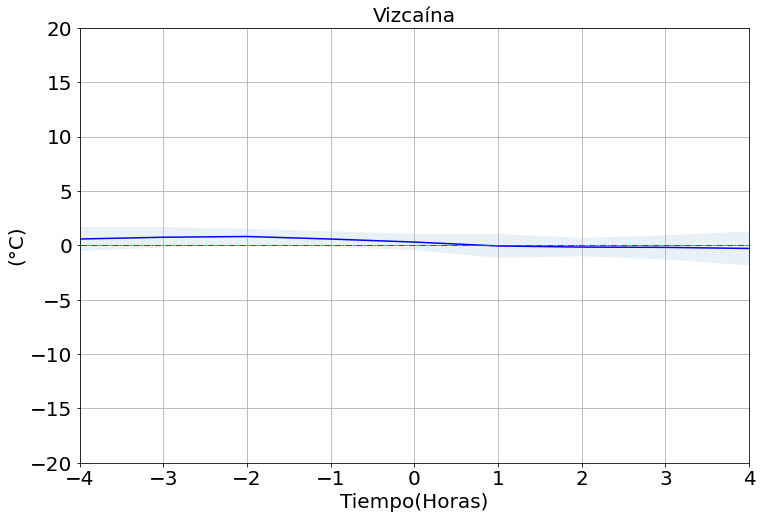

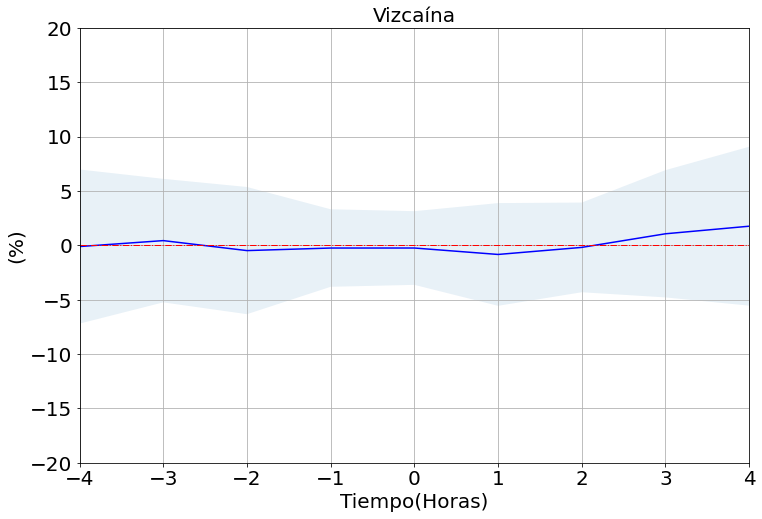

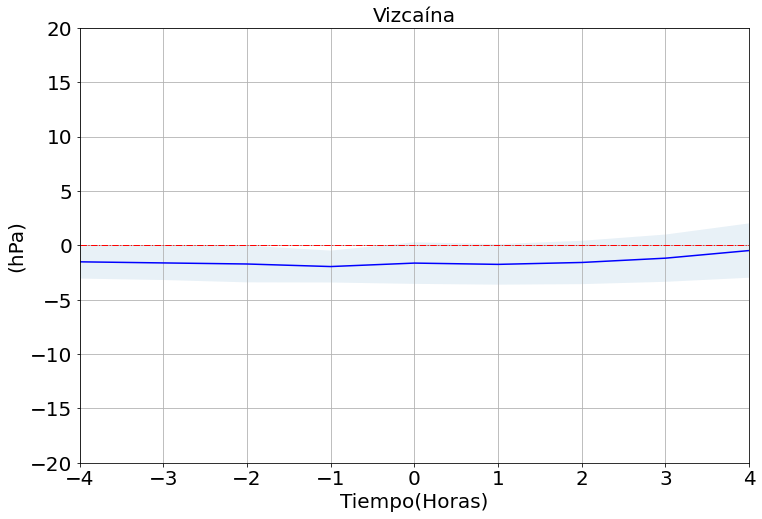

In [48]:
dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(%)'},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(hPa)'},
              # 'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomaliaVarsComp, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

# Análisis para Dirección del Viento 

In [23]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[x], df[y])) if np.arctan2(df[x], df[y]) > 0 else 360 + np.rad2deg(np.arctan2(df[x], df[y]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

# df10mean['DIRVIENTO_mean'] = df10mean.apply(func_dir, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
# df10mean['VELVIENTO_mean'] = df10mean.apply(func_vel, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
df10m['DIRVIENTO'] = df10m.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
df10m['VELVIENTO'] = df10m.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

In [24]:
df10m

,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,FECHA,DIRVIENTO,VELVIENTO
0,2011-01-02 00,-0.063847,-0.596293,00,2011-01-02 00:00:00-05:00,186.111533,0.599702
1,2011-01-02 01,-0.076218,-0.559301,01,2011-01-02 01:00:00-05:00,187.760136,0.564470
2,2011-01-02 02,-0.034522,-0.431268,02,2011-01-02 02:00:00-05:00,184.576598,0.432647
3,2011-01-02 03,-0.077836,-0.493173,03,2011-01-02 03:00:00-05:00,188.968875,0.499277
4,2011-01-02 04,-0.127415,-0.483384,04,2011-01-02 04:00:00-05:00,194.766700,0.499895
...,...,...,...,...,...,...,...
24116,2017-12-31 19,-0.258113,0.324864,19,2017-12-31 19:00:00-05:00,321.531924,0.414921
24117,2017-12-31 20,0.026130,0.282996,20,2017-12-31 20:00:00-05:00,5.275413,0.284200
24118,2017-12-31 21,0.014230,0.216092,21,2017-12-31 21:00:00-05:00,3.767688,0.216560
24119,2017-12-31 22,0.487289,0.111343,22,2017-12-31 22:00:00-05:00,77.129189,0.499848


# Cargando Eventos e encontrando intervalo m minutos antes y después

In [25]:
funtimeMinutes = lambda x, minute : [x + timedelta(minutes = h) for h in (range(0, minute+1, 10) if minute > 0 else range(minute, 0, 10))]

dfEventAnMin = dfEventos.copy()

dfEventAnMin['FECHA_ANTES_MIN'] = dfEventAnMin['FECHA_MIN'].apply(funtimeMinutes, minute = -int_minutes)
dfEventAnMin['FECHA_DESPUES_MIN'] = dfEventAnMin['FECHA_MIN'].apply(funtimeMinutes, minute = int_minutes)

dfEventAnMin['FECHA_INTERVALO'] = dfEventAnMin['FECHA_ANTES_MIN'] + dfEventAnMin['FECHA_DESPUES_MIN']
dfEventAnMin = dfEventAnMin.drop(columns=['FECHA_ANTES_MIN', 'FECHA_DESPUES_MIN']).explode('FECHA_INTERVALO')
dfEventAnMin['FECHA_POS'] = (dfEventAnMin['FECHA_INTERVALO'] - dfEventAnMin['FECHA_MIN'])/ pd.Timedelta(minutes=1)
dfEventAnMin = dfEventAnMin.rename(columns={'FECHA_MIN' : 'FECHA_EVENTO', 'FECHA': 'FECHA_HORA', 'FECHA_INTERVALO': 'FECHA'}).reset_index(drop=True)
dfEventAnMin['FECHA'] = dfEventAnMin['FECHA'].astype(str)

dfEventAnMin.head(10)

,FECHA_HORA,FECHA_EVENTO,min_t,lon_t,lat_t,FECHA,FECHA_POS
0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:20:00-05:00,-240.0
1,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:30:00-05:00,-230.0
2,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:40:00-05:00,-220.0
3,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:50:00-05:00,-210.0
4,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 02:00:00-05:00,-200.0
5,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 02:10:00-05:00,-190.0
6,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 02:20:00-05:00,-180.0
7,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 02:30:00-05:00,-170.0
8,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 02:40:00-05:00,-160.0
9,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 02:50:00-05:00,-150.0


In [26]:
dfCrossPrec = pd.merge(dfEventAnMin, dfPrec, on='FECHA', how = 'left')

dfCrossPrecGroup = dfCrossPrec.groupby("FECHA_POS").agg({"PREC" : ["mean", "std"]})
dfCrossPrecGroup = dfCrossPrecGroup.rename(columns = {("PREC", "mean") : "PREC_mean", ("PREC", "std") : "PREC_std"}).reset_index()

dfCrossPrecGroup

FECHA_POS      PREC          
                  mean       std
0     -240.0  0.000000  0.000000
1     -230.0  0.003333  0.018257
2     -220.0  0.000000  0.000000
3     -210.0  0.000000  0.000000
4     -200.0  0.000000  0.000000
5     -190.0  0.003333  0.018257
6     -180.0  0.000000  0.000000
7     -170.0  0.000000  0.000000
8     -160.0  0.136667  0.748554
9     -150.0  0.036667  0.200832
10    -140.0  0.006452  0.024973
11    -130.0  0.016129  0.073470
12    -120.0  0.193548  0.940190
13    -110.0  0.064516  0.341124
14    -100.0  0.180645  0.775637
15     -90.0  0.070968  0.262289
16     -80.0  0.358621  1.873979
17     -70.0  0.137931  0.723787
18     -60.0  0.300000  1.431283
19     -50.0  0.448276  2.019480
20     -40.0  1.337931  3.105573
21     -30.0  1.524138  3.218657
22     -20.0  1.151613  2.511291
23     -10.0  1.364516  3.295203
24       0.0  0.845161  2.282081
25      10.0  0.670968  1.750275
26      20.0  0.829032  2.674720
27      30.0  0.467742  1.337008
28      40.0  0.366667  1.389451
29      50.0  0.140000  0.369156
30      60.0  0.196667  0.655735
31      70.0  0.326667  1.332856
32      80.0  0.426667  1.865833
33      90.0  0.090000  0.236862
34     100.0  0.062500  0.158114
35     110.0  0.068750  0.203894
36     120.0  0.034375  0.115310
37     130.0  0.056250  0.179493
38     140.0  0.061290  0.174504
39     150.0  0.038710  0.130837
40     160.0  0.018750  0.089578
41     170.0  0.009375  0.039015
42     180.0  0.018750  0.064446
43     190.0  0.015625  0.036890
44     200.0  0.106250  0.529112
45     210.0  0.043750  0.212417
46     220.0  0.021875  0.106965
47     230.0  0.025000  0.141421
48     240.0  0.034375  0.194454

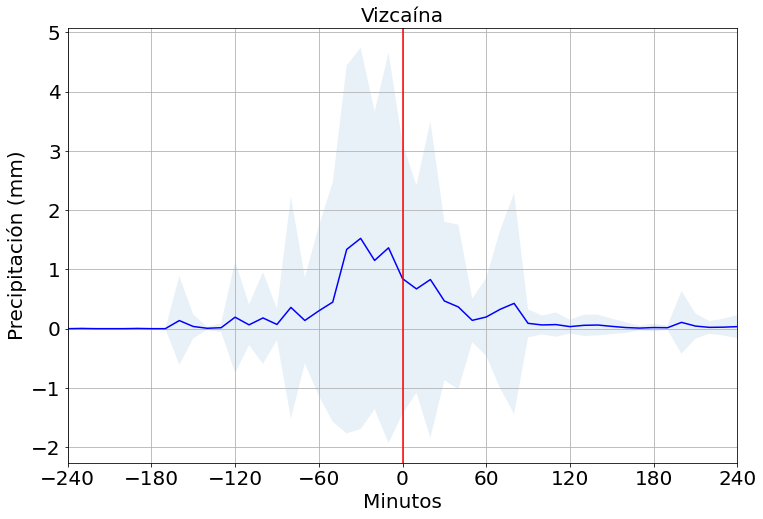

In [27]:
def plot_10m_interval(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  if has_std:
    plt.plot(df['FECHA_POS'], df[(campo, 'mean')], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[(campo, 'mean')] + df[(campo, 'std')], df[(campo, 'mean')] - df[(campo, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  # plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'PREC' : {'title' : 'Análisis de Precipitación de eventos convectivos', 'name2save' : f'analisis_prec_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Precipitación (mm)'},

    }

for key in dict_names.keys():
  plot_10m_interval(dfCrossPrecGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes)


# Análisis de percentiles - Precipitación

In [28]:
def plot_percentil_interval_prec(df, campos, campo_analizar, titulo, name_to_save, ylabel_name, int_minutes, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0

  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency],fontsize=20)
  plt.yticks(fontsize=20)
  if not .5 in campos:
    campos.append(.5)
  #for campo in campos:
    #plt.plot(df['FECHA_POS'], df[campo], label = f"Percentil {campo}")
  #plt.plot(df['FECHA_POS'], df[.5], label = f"Percentil")
  ## Gráfica del promedio 
  plt.plot(df['FECHA_POS'], df[(campo_analizar, 'mean')], linestyle = '--')

  ## Gráfica de la desviación standard
  plt.fill_between(df['FECHA_POS'], df[campos[0]] , df[campos[1]], alpha=.1, linestyle = '--', linewidth = 0.5)
  
  plt.axvline(color = 'r')
  plt.grid()
  plt.xlim([-int_minutes, int_minutes])
  plt.ylim(0,5)
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize=20)
  plt.ylabel(ylabel_name, fontsize=20)
  plt.title("Vizcaína", fontsize=20)
  plt.legend()

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,


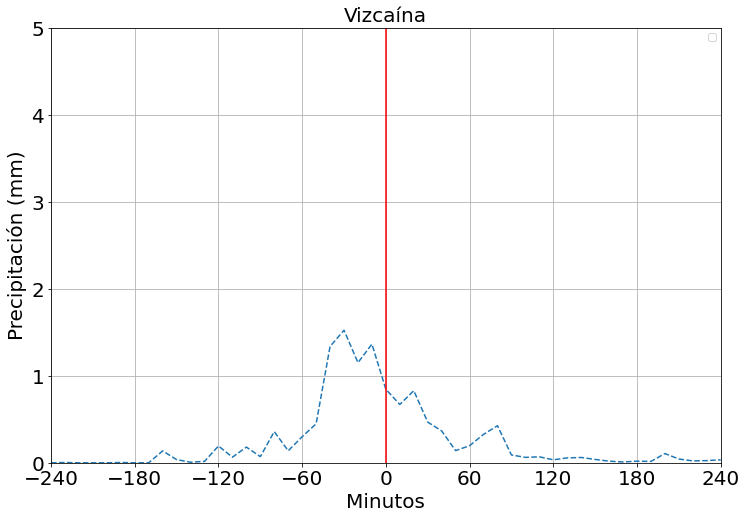

In [29]:
list_percentil = [ 0.05, .1, .20, .25, .50, .75, .80, .90, 0.95]
dfCrossPrecNotNan = dfCrossPrec.dropna().reset_index()
dfPercentilPrec= dfCrossPrecNotNan.groupby("FECHA_POS")['PREC'].quantile(list_percentil).reset_index()
dfAggPrec = dfCrossPrecNotNan.groupby("FECHA_POS").agg({"PREC" : ["mean", "std"]})

dfPercentilPrec = dfPercentilPrec.pivot(index='FECHA_POS', columns='level_1')['PREC'].reset_index()
dfPercentilPrec = dfPercentilPrec.join(dfAggPrec, "FECHA_POS")

dict_names = {'title' : 'Análisis de precipitación', 
              'name2save' : f'analisis_precipitacion_percentil_{NOMBRE_ESTACION}_{int_minutes}m.png', 
              'ylabel' : 'Precipitación (mm)'
              }

plot_percentil_interval_prec(dfPercentilPrec, [.10, .10], 'PREC', dict_names['title'], dict_names['name2save'], dict_names['ylabel'], int_minutes)

# Análisis de Viento

In [30]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[x], df[y])) if np.arctan2(df[x], df[y]) > 0 else 360 + np.rad2deg(np.arctan2(df[x], df[y]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

In [31]:
dfCrossVientos = pd.merge(dfEventAnMin, dfViento, on='FECHA', how = 'left')
# dfCrossVientos = dfCrossVientos.loc[dfCrossVientos['FECHA_POS'] == 240]
dfCrossVientos["X_VIENTO_STD"] = dfCrossVientos["X_VIENTO"]
dfCrossVientos["Y_VIENTO_STD"] = dfCrossVientos["Y_VIENTO"]


dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"X_VIENTO" : "mean", "Y_VIENTO" : "mean", "X_VIENTO_STD" : "std", "Y_VIENTO_STD" : "std"}).reset_index()
# dfCrossPrecGroup = dfCrossPrecGroup.rename(columns = {("PREC", "mean") : "PREC_mean", ("PREC", "std") : "PREC_std"}).reset_index()

dfCrossVientosGroup['DIR_VIENTO'] = dfCrossVientosGroup.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosGroup['DIR_VIENTO'] = (dfCrossVientosGroup['DIR_VIENTO'] + 180.0) % 360
dfCrossVientosGroup['VEL_VIENTO'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosGroup['VEL_VIENTO_MEAN'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosGroup['VEL_VIENTO_STD'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO_STD', y='Y_VIENTO_STD', axis=1)


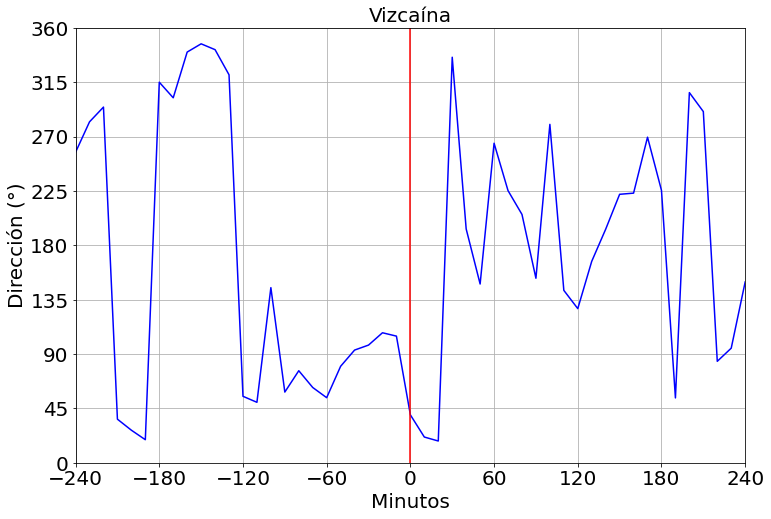

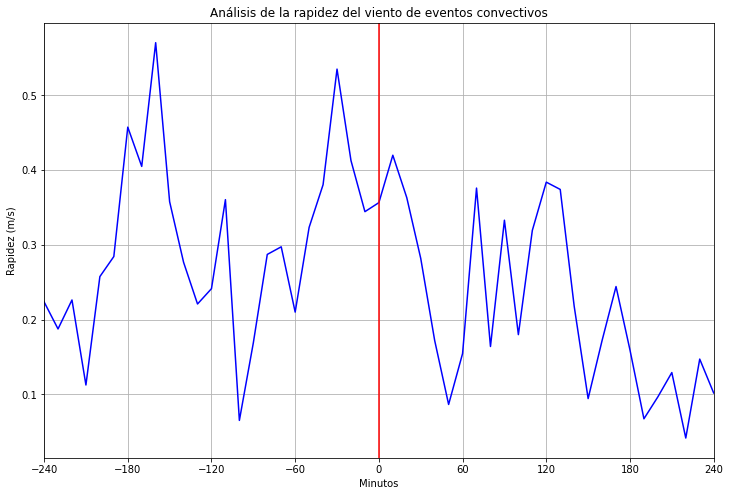

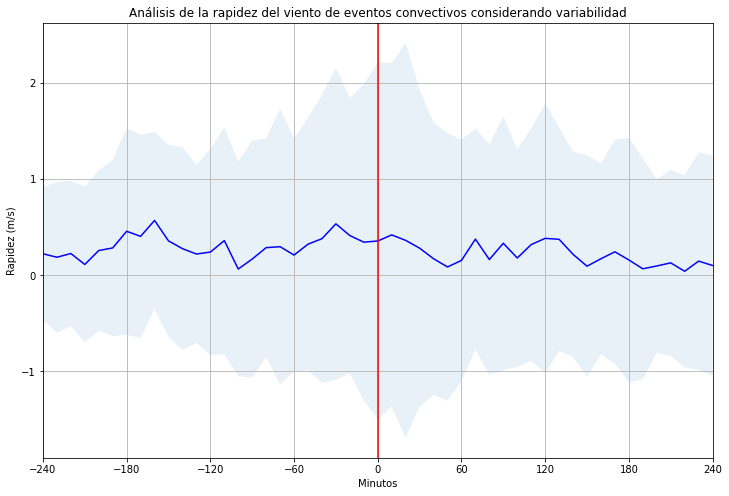

In [32]:
def plot_10m_interval_v2(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency])
  if has_std:
    plt.plot(df['FECHA_POS'], df[f"{campo}_MEAN"], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[f"{campo}_MEAN"] + df[f"{campo}_STD"], df[f"{campo}_MEAN"] - df[f"{campo}_STD"], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  # plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos")
  plt.ylabel(ylabel_name)
  plt.title(titulo)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

def plot_dir_viento_interval(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  plt.yticks(range(0, 361, 45))
  if has_std:
    plt.plot(df['FECHA_POS'], df[f"{campo}_MEAN"], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[f"{campo}_MEAN"] + df[f"{campo}_STD"], df[f"{campo}_MEAN"] - df[f"{campo}_STD"], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'DIR_VIENTO' : {'title' : 'Análisis de la dirección del viento de eventos convectivos', 'name2save' : f'analisis_dir_viento_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Dirección (°)'},
              'VEL_VIENTO' : {'title' : 'Análisis de la rapidez del viento de eventos convectivos', 'name2save' : f'analisis_vel_viento_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Rapidez (m/s)'},
              'VEL_VIENTO_2' : {'title' : 'Análisis de la rapidez del viento de eventos convectivos considerando variabilidad', 'name2save' : f'analisis_vel_viento_std_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Rapidez (m/s)'},
             }

key = 'DIR_VIENTO'
plot_dir_viento_interval(dfCrossVientosGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, ylimit = [0, 360], has_std=False)

key = 'VEL_VIENTO'
plot_10m_interval_v2(dfCrossVientosGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, has_std=False)

key = 'VEL_VIENTO_2'
plot_10m_interval_v2(dfCrossVientosGroup, 'VEL_VIENTO', dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, has_std=True)

## Anáisis de Percentiles

In [33]:
dfCrossVientos

,FECHA_HORA_x,FECHA_EVENTO,min_t,lon_t,lat_t,FECHA,FECHA_POS,DIRECVIENTO,VELVIENTO,FECHA_HORA_y,X_VIENTO,Y_VIENTO,X_VIENTO_STD,Y_VIENTO_STD
0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:20:00-05:00,-240.0,1.0,0.4,2011-02-13 01,-0.006981,-0.399939,-0.006981,-0.399939
1,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:30:00-05:00,-230.0,5.0,0.5,2011-02-13 01,-0.043578,-0.498097,-0.043578,-0.498097
2,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:40:00-05:00,-220.0,5.0,0.8,2011-02-13 01,-0.069725,-0.796956,-0.069725,-0.796956
3,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:50:00-05:00,-210.0,6.0,1.0,2011-02-13 01,-0.104528,-0.994522,-0.104528,-0.994522
4,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 02:00:00-05:00,-200.0,7.0,1.0,2011-02-13 02,-0.121869,-0.992546,-0.121869,-0.992546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,2017-11-26 03:00:00-05:00,2017-11-26 03:20:00-05:00,223.2,-73.693,6.772,2017-11-26 06:40:00-05:00,200.0,305.0,0.5,2017-11-26 06,0.409576,-0.286788,0.409576,-0.286788
1907,2017-11-26 03:00:00-05:00,2017-11-26 03:20:00-05:00,223.2,-73.693,6.772,2017-11-26 06:50:00-05:00,210.0,302.0,0.7,2017-11-26 06,0.593634,-0.370943,0.593634,-0.370943
1908,2017-11-26 03:00:00-05:00,2017-11-26 03:20:00-05:00,223.2,-73.693,6.772,2017-11-26 07:00:00-05:00,220.0,329.0,0.9,2017-11-26 07,0.463534,-0.771451,0.463534,-0.771451
1909,2017-11-26 03:00:00-05:00,2017-11-26 03:20:00-05:00,223.2,-73.693,6.772,2017-11-26 07:10:00-05:00,230.0,319.0,0.8,2017-11-26 07,0.524847,-0.603768,0.524847,-0.603768


In [34]:
def plot_percentil_interval(df, campos, campo_analizar, titulo, name_to_save, ylabel_name, int_minutes, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0

  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  if not .5 in campos:
    campos.append(.5)
  #for campo in campos:
    #plt.plot(df['FECHA_POS'], df[campo], label = f"Percentil {campo}")
  plt.plot(df['FECHA_POS'], df[0.5], label = f"Percentil {0.5}")
  ## Gráfica del promedio 
  #plt.plot(df['FECHA_POS'], df[(campo_analizar, 'mean')], linestyle = '--')

  ## Gráfica de la desviación standard
  plt.fill_between(df['FECHA_POS'], df[campos[0]] , df[campos[1]], alpha=.1, linestyle = '--', linewidth = 0.5)
  
  # plt.axvline(color = 'r')
  plt.grid()
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 20)
  plt.legend()

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,


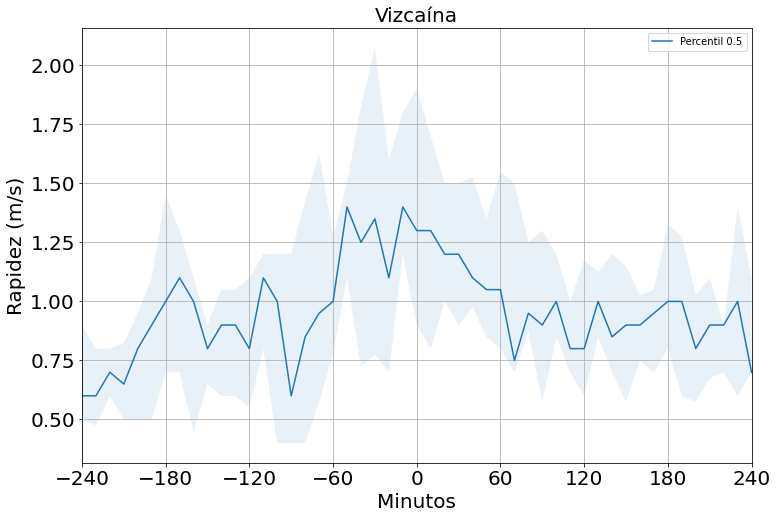

In [35]:
list_percentil = [.10, .20,.25, .50, .75, .80, .90]
dfPercentilViento = dfCrossVientos.groupby("FECHA_POS")['VELVIENTO'].quantile(list_percentil).reset_index()
dfAggViento = dfCrossVientos.groupby("FECHA_POS").agg({"VELVIENTO" : ["mean", "std"]})

dfPercentilViento = dfPercentilViento.pivot(index='FECHA_POS', columns='level_1')['VELVIENTO'].reset_index()
dfPercentilViento = dfPercentilViento.join(dfAggViento, "FECHA_POS")

dict_names = {'title' : 'Análisis de rapidez del viento', 
              'name2save' : f'analisis_rapidez_viento_percentil_{NOMBRE_ESTACION}_{int_minutes}m.png', 
              'ylabel' : 'Rapidez (m/s)'
              }

plot_percentil_interval(dfPercentilViento, [.25, .75], 'VELVIENTO', dict_names['title'], dict_names['name2save'], dict_names['ylabel'], int_minutes)

# Análisis de viento por hora

In [36]:
dfCrossVientosHora = pd.merge(dfEventAn, df10m, on='FECHA', how = 'left')

dfCrossVientosHora
# dfCrossVientosHoraGroup = dfCrossVientosHora.groupby("FECHA_POS").agg({"X_VIENTO" : "mean", "Y_VIENTO" : "mean"}).reset_index()

dfCrossVientosHora['DIR_VIENTO'] = dfCrossVientosHora.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosHora['DIR_VIENTO'] = (dfCrossVientosHora['DIR_VIENTO'] + 180.0) % 360
dfCrossVientosHora['VEL_VIENTO'] = dfCrossVientosHora.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

dfCrossVientosHora

,index,FECHA_EVENTO,FECHA_MIN,min_t,lon_t,lat_t,FECHA,FECHA_POS,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,DIRVIENTO,VELVIENTO,DIR_VIENTO,VEL_VIENTO
0,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:00:00-05:00,-4.0,2011-02-13 01,-0.059542,-0.680530,01,185.000297,0.683130,5.000297,0.683130
1,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 02:00:00-05:00,-3.0,2011-02-13 02,-0.092994,-1.463359,02,183.636153,1.466310,3.636153,1.466310
2,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 03:00:00-05:00,-2.0,2011-02-13 03,-0.130611,-0.954654,03,187.790559,0.963548,7.790559,0.963548
3,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 04:00:00-05:00,-1.0,2011-02-13 04,-0.139804,-1.103153,04,187.222671,1.111976,7.222671,1.111976
4,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 05:00:00-05:00,0.0,2011-02-13 05,-0.322099,-3.384581,05,185.436273,3.399873,5.436273,3.399873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,38,2017-11-26 03:00:00-05:00,2017-11-26 03:20:00-05:00,223.2,-73.693,6.772,2017-11-26 03:00:00-05:00,0.0,2017-11-26 03,0.022838,0.087928,03,14.560187,0.090846,194.560187,0.090846
347,38,2017-11-26 03:00:00-05:00,2017-11-26 03:20:00-05:00,223.2,-73.693,6.772,2017-11-26 04:00:00-05:00,1.0,2017-11-26 04,-0.149542,0.442744,04,341.337008,0.467317,161.337008,0.467317
348,38,2017-11-26 03:00:00-05:00,2017-11-26 03:20:00-05:00,223.2,-73.693,6.772,2017-11-26 05:00:00-05:00,2.0,2017-11-26 05,-0.253828,0.302164,05,319.968524,0.394629,139.968524,0.394629
349,38,2017-11-26 03:00:00-05:00,2017-11-26 03:20:00-05:00,223.2,-73.693,6.772,2017-11-26 06:00:00-05:00,3.0,2017-11-26 06,0.519388,0.058852,06,83.535318,0.522712,263.535318,0.522712


In [37]:
def plot_windrose(df, title, path_to_save):
  ax = WindroseAxes.from_ax()

  ax.bar(df['DIR_VIENTO'], df['VEL_VIENTO'], normed=True, opening=0.8, bins=np.arange(0.0, 5, 0.5), edgecolor='white', cmap=cm.cool)
  ax.set_legend(loc = 3)
  ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])
  plt.title(title)
  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )
  plt.show()

In [38]:
posHoras = set(list(dfCrossVientosHora['FECHA_POS']))
posHoras

{-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0}

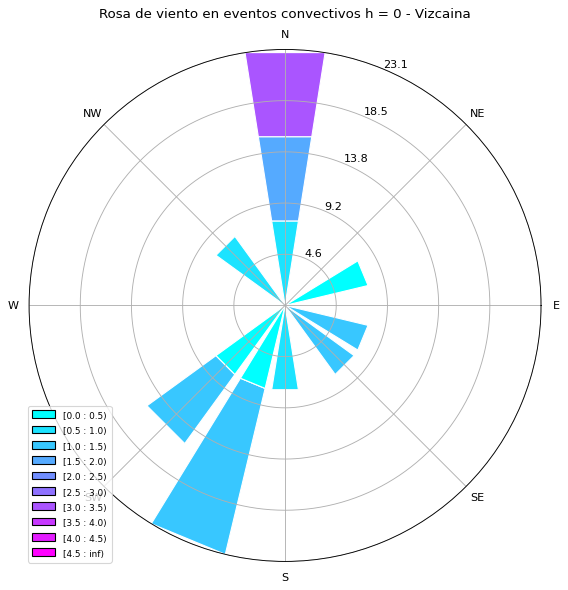

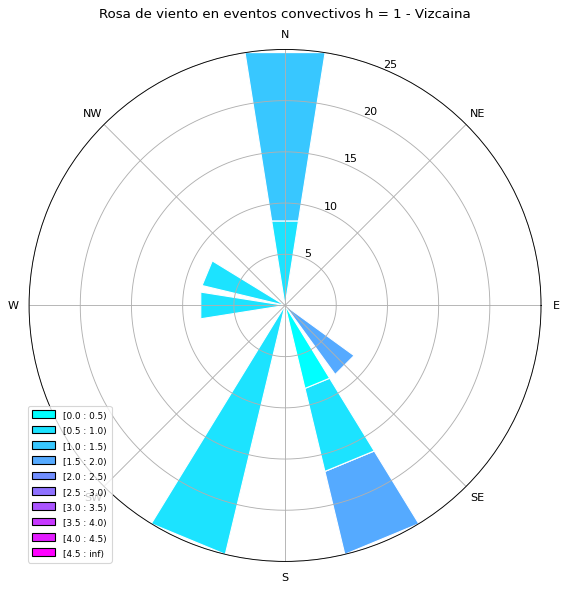

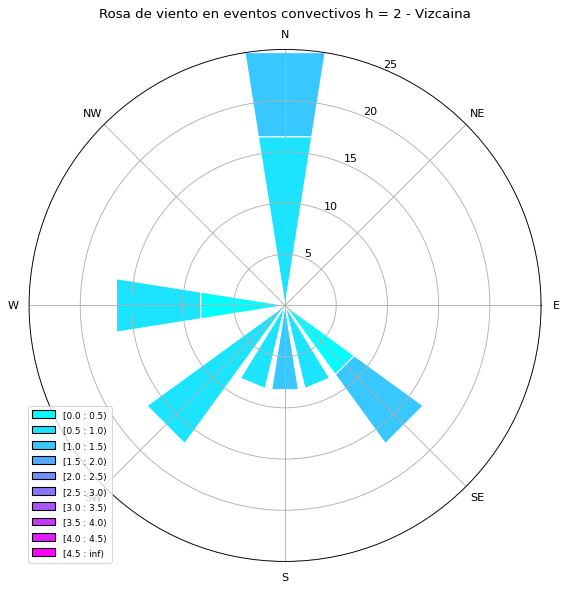

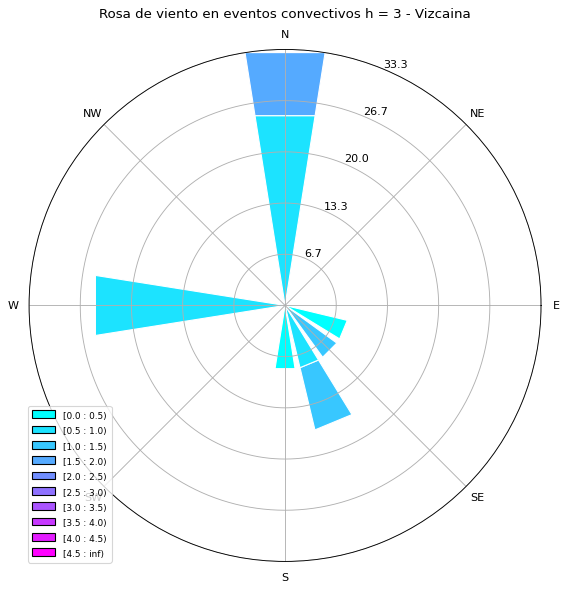

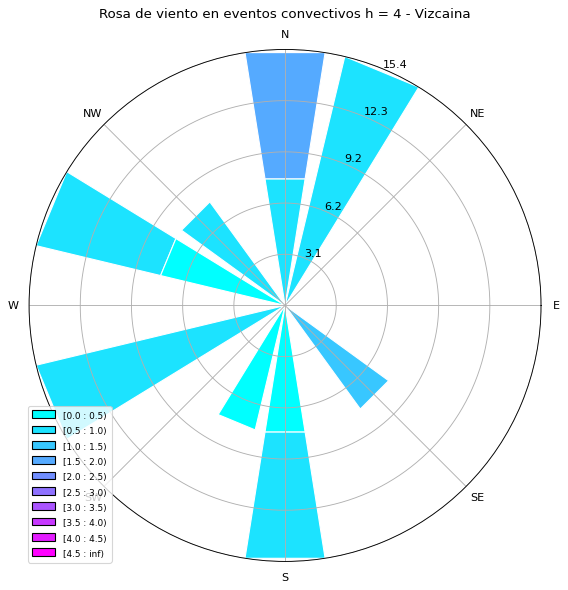

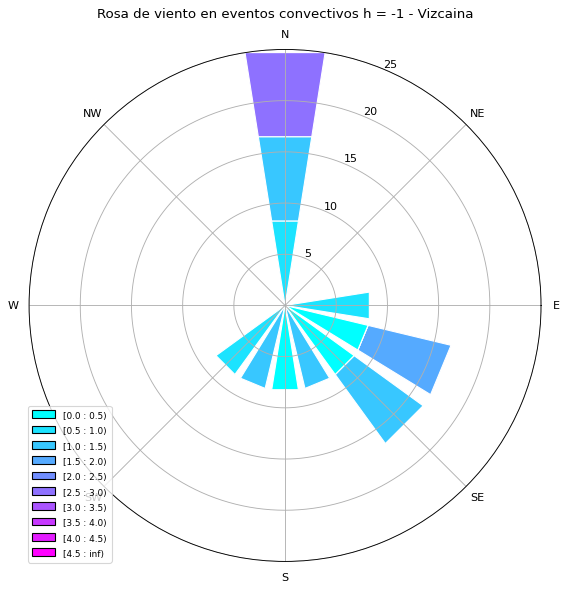

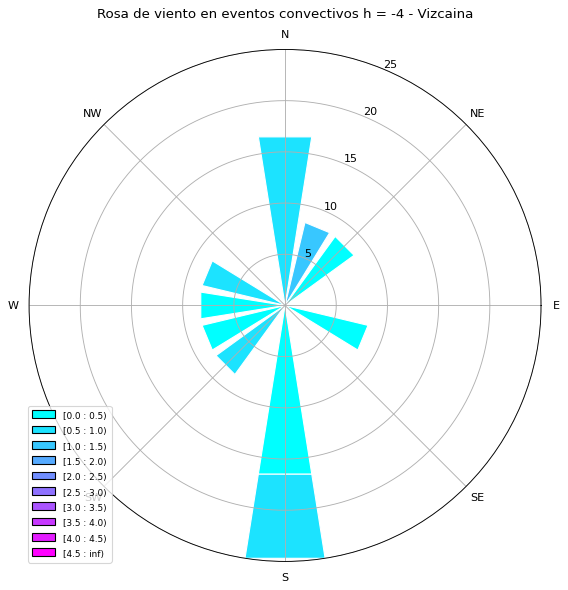

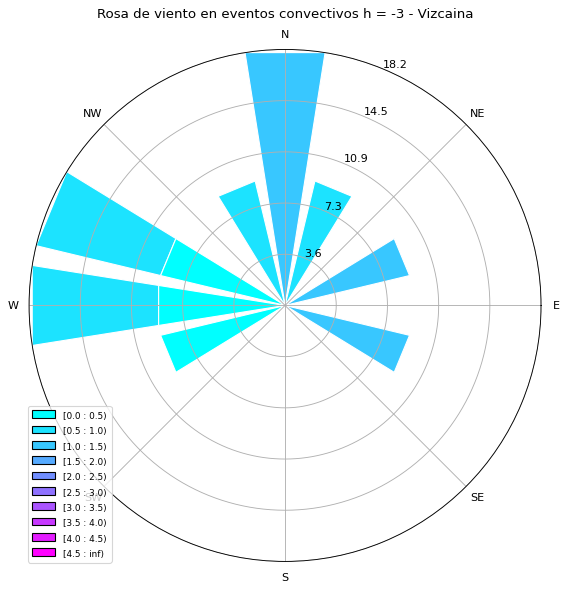

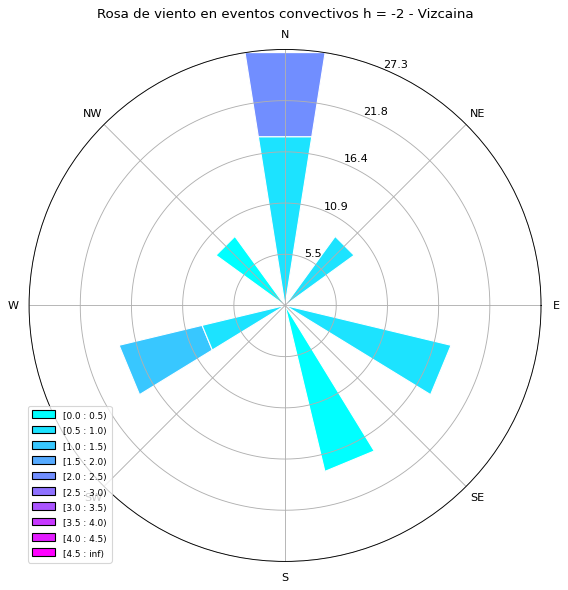

In [39]:
for hora in posHoras:
  dft = dfCrossVientosHora.loc[dfCrossVientosHora['FECHA_POS'] == hora]
  title = f'Rosa de viento en eventos convectivos h = {int(hora)} - {NOMBRE_ESTACION.capitalize()}'
  path_to_save = f'windrose_eventos_convectivos_hora_{int(hora)}_{NOMBRE_ESTACION.lower()}.png'
    
  plot_windrose(dft, title, path_to_save)

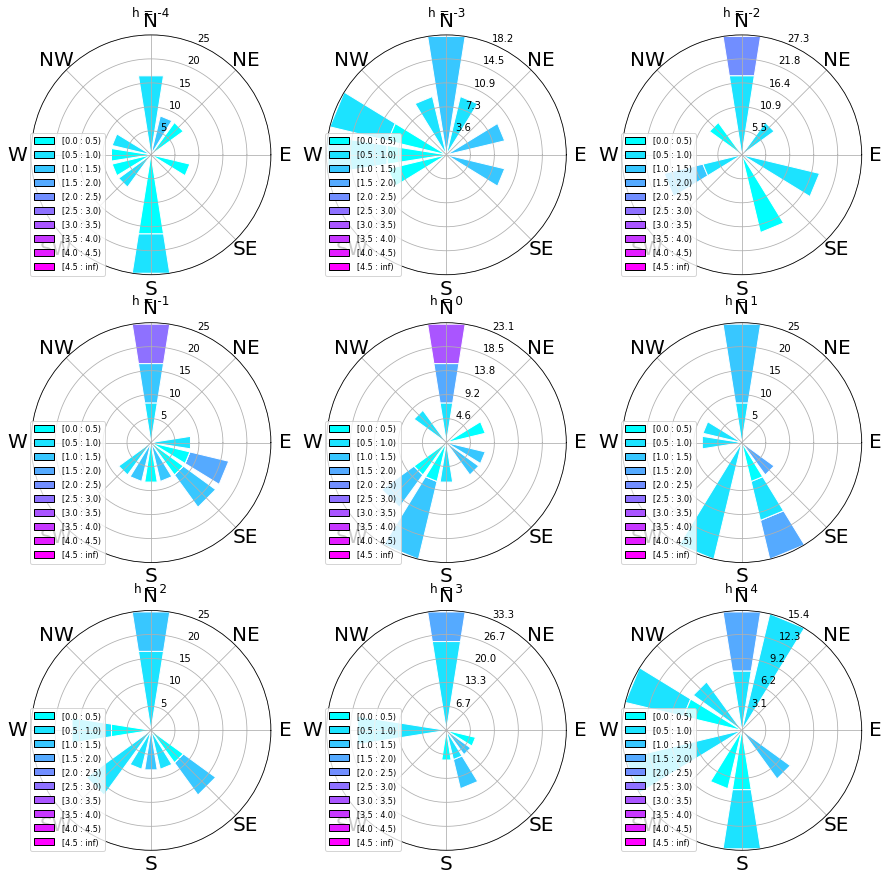

In [40]:
def plot_windrose_2(df, title, ax):
  ax.bar(df['DIR_VIENTO'], df['VEL_VIENTO'], normed=True, opening=0.8, bins=np.arange(0.0, 5, 0.5), edgecolor='white', cmap=cm.cool)
  ax.set_legend(loc = 3)
  ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'], fontsize= 20)
  ax.set_title(title)


fig, axs = plt.subplots(3, 3,figsize=(15,15),  subplot_kw=dict(projection="windrose"))
horas = list(posHoras)
horas.sort()

for ax, hora in zip(axs.reshape(9), horas):
  dft = dfCrossVientosHora.loc[dfCrossVientosHora['FECHA_POS'] == hora]
  title = f'h = {int(hora)}'
  plot_windrose_2(dft, title, ax)

path_to_save = f'subplot_vientos_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )
plt.show()

# Gráficos multivariables en único Plot

In [41]:
dfAnomalia

FECHA_POS TEMP_anomalia           HUM_anomalia           PRESION_anomalia  \
                     mean       std         mean       std             mean   
0        -4      0.436687  0.970946    -0.075357  6.204664        -1.514169   
1        -3      0.572162  0.872019     0.290817  4.981313        -1.615179   
2        -2      0.637224  0.749931    -0.192930  5.072356        -1.061479   
3        -1      0.490207  0.724360    -0.205052  3.239644        -1.949233   
4         0      0.154805  1.071114     0.213712  2.909260        -1.630833   
5         1     -0.257778  1.209719    -0.188297  3.951062        -1.748815   
6         2     -0.509879  1.021251     0.190342  3.440603        -1.450860   
7         3     -0.682358  1.431416     2.160698  5.955865        -0.452696   
8         4     -0.866734  1.953887     3.489394  8.256050         0.295160   

            CERO  
        std       
0  1.540589    0  
1  1.572097    0  
2  3.414321    0  
3  1.466341    0  
4  1.911505    0  
5  1.865688    0  
6  2.021517    0  
7  3.533626    0  
8  3.687665    0

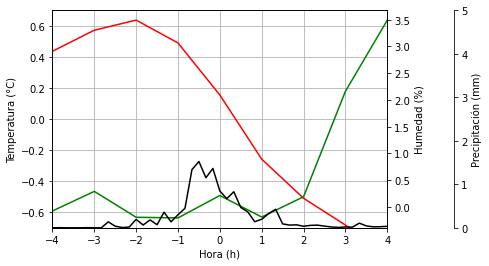

In [42]:
fig, ax = plt.subplots()
ax.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('TEMP_anomalia', 'mean')], c = 'red')
ax.set_ylim(-0.7, 0.7)

ax2=ax.twinx()
ax2.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('HUM_anomalia', 'mean')], c = 'green')

ax3=ax.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
ax3.plot(dfCrossPrecGroup['FECHA_POS']/60.0, dfCrossPrecGroup[('PREC', 'mean')], c = 'black')
ax3.set_ylim(0, 5)

ax.set_xlim(-4, 4)
ax.grid()

ax.set_ylabel("Temperatura (°C)")
ax2.set_ylabel("Humedad (%)")
ax3.set_ylabel("Precipitación (mm)")
ax.set_xlabel("Hora (h)")

path_to_save = f'temp_vs_hum_vs_prec_anomalias_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )

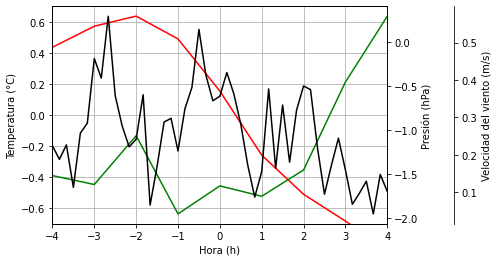

In [43]:
fig, ax = plt.subplots()
ax.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('TEMP_anomalia', 'mean')], c = 'red')
ax.set_ylim(-0.7, 0.7)

ax2=ax.twinx()
ax2.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('PRESION_anomalia', 'mean')], c = 'green')

ax3=ax.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
ax3.plot(dfCrossVientosGroup['FECHA_POS']/60.0, dfCrossVientosGroup['VEL_VIENTO'], c = 'black')
# ax3.set_ylim(0, 0.5)

ax.set_xlim(-4, 4)
ax.grid()

ax.set_ylabel("Temperatura (°C)")
ax2.set_ylabel("Presión (hPa)")
ax3.set_ylabel("Velocidad del viento (m/s)")
ax.set_xlabel("Hora (h)")

path_to_save = f'temp_vs_pres_vs_velviento_anomalias_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )